In [1]:
import sys
sys.path.append("..")
%cd ..

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1


In [48]:
from scipy.stats import norm
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score, mean_squared_error
from DataPrep.load_data import load_data
from DataPrep.LagCreation import lags
from Tobit import Tobit
from sklearn.preprocessing import StandardScaler


In [49]:
df = load_data()

In [50]:
l = lags()

In [51]:
testdata = df[df.Label == 0]


In [52]:
scaler = StandardScaler()
testdata["Energy (kWh)"] = scaler.fit_transform(np.array(testdata["Energy (kWh)"]).reshape(-1,1))

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
testdata = testdata.drop(columns=["Charging Time (mins)","Parking Time (mins)",'# Professional & Other Places',
 '# Food',
 '# Shop & Service',
 '# Travel & Transport',
 '# Outdoors & Recreation',
 '# Arts & Entertainment',
 '# Nightlife Spot',
 '# Residence',
 '# College & University',
 '# Event',
 'Label_0',
 'Label_1',
 'Label_2',
 'Label_3',
 'Label_4',
 'Label_5',
 'Label_6',
 'Label_7'])

In [54]:
 testdata.columns

Index(['Label', 'Energy (kWh)', 'Fee (USD)', 'Plugs', 'Month_Day_1',
       'Month_Day_2', 'Month_Day_3', 'Month_Day_4', 'Month_Day_5',
       'Month_Day_6', 'Month_Day_7', 'Month_Day_8', 'Month_Day_9',
       'Month_Day_10', 'Month_Day_11', 'Month_Day_12', 'Month_Day_13',
       'Month_Day_14', 'Month_Day_15', 'Month_Day_16', 'Month_Day_17',
       'Month_Day_18', 'Month_Day_19', 'Month_Day_20', 'Month_Day_21',
       'Month_Day_22', 'Month_Day_23', 'Month_Day_24', 'Month_Day_25',
       'Month_Day_26', 'Month_Day_27', 'Month_Day_28', 'Month_Day_29',
       'Month_Day_30', 'Month_Day_31', 'Week_Day_0', 'Week_Day_1',
       'Week_Day_2', 'Week_Day_3', 'Week_Day_4', 'Week_Day_5', 'Week_Day_6',
       'Year_Month_1', 'Year_Month_2', 'Year_Month_3', 'Year_Month_4',
       'Year_Month_5', 'Year_Month_6', 'Year_Month_7', 'Year_Month_8',
       'Year_Month_9', 'Year_Month_10', 'Year_Month_11', 'Year_Month_12'],
      dtype='object')

In [55]:
for i in range(1,13):
    testdata[f"Year_Month_{i}"] = 0
    testdata[f"Year_Month_{i}"][(testdata.index.month==i) & (testdata.index.day==1)] = 1
testdata[f"Year_Month_{testdata.index[0].month}"]=1

c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\frede\OneDrive - Danmarks Tekniske Universitet\DTU\6. Semester\Bachelor2021-1\env\lib\site-packag

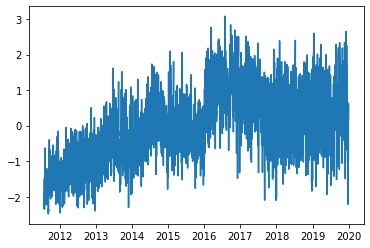

In [56]:
plt.plot(testdata["Energy (kWh)"])
plt.show()

In [57]:
def censor(s):
    energy = s["Energy (kWh)"] 
    energy_lag1 = s["Energy (kWh)_lag1"]
    energy_lag2 = s["Energy (kWh)_lag2"]
    energy_lag3 = s["Energy (kWh)_lag3"]
    energy_lag4 = s["Energy (kWh)_lag4"]
    energy_lag5 = s["Energy (kWh)_lag5"]

    s["Censored"] = False
    if energy > 0.5:
        s["Energy (kWh)"] = 0.5
        s["Censored"] = True
    if energy_lag1 > 0.5:
        s["Energy (kWh)_lag1"] = 0.5
    if energy_lag2 > 0.5:
        s["Energy (kWh)_lag2"] = 0.5
    if energy_lag3 > 0.5:
        s["Energy (kWh)_lag3"] = 0.5
    if energy_lag4 > 0.5:
        s["Energy (kWh)_lag4"] = 0.5
    if energy_lag5 > 0.5:
        s["Energy (kWh)_lag5"] = 0.5
    
    return s

In [58]:
testdata = l.buildLaggedFeatures(testdata,["Energy (kWh)"])

In [59]:
testdata = testdata.apply(censor, axis=1)

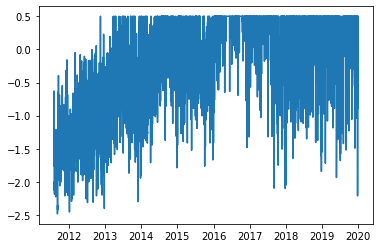

In [60]:
plt.plot(testdata["Energy (kWh)"])
plt.show()

In [64]:
testdata[testdata["Censored"] == False].shape

(2050, 60)

In [65]:
t = Tobit(testdata, 'Censored', list(testdata.drop(columns=["Energy (kWh)","Censored"]).columns), 'Energy (kWh)')

In [66]:
regressor = LinearRegression(fit_intercept=False).fit(testdata.drop(columns=["Energy (kWh)", "Censored"]), testdata["Energy (kWh)"])
pred = regressor.predict(testdata.drop(columns=["Energy (kWh)","Censored"]))

In [67]:
vars = regressor.coef_


In [68]:
vars = np.append(vars,1)

In [69]:
vars

array([ 2.24608578e+03,  6.38834526e-03, -3.31307071e+07, -1.22053465e+07,
       -1.22053464e+07, -1.22053465e+07, -1.22053465e+07, -1.22053463e+07,
       -1.22053463e+07, -1.22053463e+07, -1.22053465e+07, -1.22053464e+07,
       -1.22053464e+07, -1.22053464e+07, -1.22053464e+07, -1.22053463e+07,
       -1.22053464e+07, -1.22053464e+07, -1.22053464e+07, -1.22053464e+07,
       -1.22053464e+07, -1.22053464e+07, -1.22053464e+07, -1.22053465e+07,
       -1.22053465e+07, -1.22053464e+07, -1.22053465e+07, -1.22053465e+07,
       -1.22053464e+07, -1.22053464e+07, -1.22053465e+07, -1.22053464e+07,
       -1.22053463e+07, -1.22053464e+07, -4.03425938e+07, -4.03425937e+07,
       -4.03425937e+07, -4.03425938e+07, -4.03425938e+07, -4.03425943e+07,
       -4.03425945e+07, -5.09429824e-01,  1.48362440e-01,  1.22559501e-01,
        5.31613338e-03,  1.55260953e-01,  2.89663589e-01,  1.85070769e+08,
        1.90775368e-01, -1.05335351e-01,  2.59927394e-01,  2.30900988e-01,
        1.58188459e-01,  

In [70]:
minimizer = t.minimize(vars)

In [71]:
minimizer["x"]

array([ 2.24608578e+03,  7.38444624e-02, -3.31307068e+07, -1.22053466e+07,
       -1.22053465e+07, -1.22053463e+07, -1.22053465e+07, -1.22053465e+07,
       -1.22053463e+07, -1.22053464e+07, -1.22053464e+07, -1.22053461e+07,
       -1.22053468e+07, -1.22053465e+07, -1.22053461e+07, -1.22053460e+07,
       -1.22053467e+07, -1.22053465e+07, -1.22053468e+07, -1.22053464e+07,
       -1.22053465e+07, -1.22053464e+07, -1.22053466e+07, -1.22053463e+07,
       -1.22053465e+07, -1.22053466e+07, -1.22053468e+07, -1.22053464e+07,
       -1.22053461e+07, -1.22053467e+07, -1.22053471e+07, -1.22053464e+07,
       -1.22053458e+07, -1.22053465e+07, -4.03425935e+07, -4.03425933e+07,
       -4.03425933e+07, -4.03425938e+07, -4.03425932e+07, -4.03425949e+07,
       -4.03425942e+07, -4.29292452e-01,  1.39233207e-01,  1.41730050e-01,
        5.31613338e-03,  2.35182126e-01,  3.33288921e-01,  1.85070768e+08,
        1.84101377e-01, -1.14870011e-01,  2.59910000e-01,  2.30384225e-01,
        1.44600569e-01,  

In [72]:
sd = minimizer['x'][-1]
beta = minimizer['x'][:-1]

"""
Når sd er sat i tobit scriptet skal beta være hele outputtet fra minimizer
"""

#beta = minimizer["x"]

In [73]:
#sd

In [76]:
beta

array([ 2.24608578e+03,  7.38444624e-02, -3.31307068e+07, -1.22053466e+07,
       -1.22053465e+07, -1.22053463e+07, -1.22053465e+07, -1.22053465e+07,
       -1.22053463e+07, -1.22053464e+07, -1.22053464e+07, -1.22053461e+07,
       -1.22053468e+07, -1.22053465e+07, -1.22053461e+07, -1.22053460e+07,
       -1.22053467e+07, -1.22053465e+07, -1.22053468e+07, -1.22053464e+07,
       -1.22053465e+07, -1.22053464e+07, -1.22053466e+07, -1.22053463e+07,
       -1.22053465e+07, -1.22053466e+07, -1.22053468e+07, -1.22053464e+07,
       -1.22053461e+07, -1.22053467e+07, -1.22053471e+07, -1.22053464e+07,
       -1.22053458e+07, -1.22053465e+07, -4.03425935e+07, -4.03425933e+07,
       -4.03425933e+07, -4.03425938e+07, -4.03425932e+07, -4.03425949e+07,
       -4.03425942e+07, -4.29292452e-01,  1.39233207e-01,  1.41730050e-01,
        5.31613338e-03,  2.35182126e-01,  3.33288921e-01,  1.85070768e+08,
        1.84101377e-01, -1.14870011e-01,  2.59910000e-01,  2.30384225e-01,
        1.44600569e-01,  

In [77]:
dict(zip(regressor.coef_.round(4),list(testdata.drop(columns=["Energy (kWh)","Censored"]))))

{2246.0858: 'Label',
 0.0064: 'Fee (USD)',
 -33130707.1245: 'Plugs',
 -12205346.5434: 'Month_Day_1',
 -12205346.4159: 'Month_Day_2',
 -12205346.4544: 'Month_Day_3',
 -12205346.4811: 'Month_Day_4',
 -12205346.3467: 'Month_Day_5',
 -12205346.3176: 'Month_Day_6',
 -12205346.3444: 'Month_Day_7',
 -12205346.4513: 'Month_Day_8',
 -12205346.4193: 'Month_Day_9',
 -12205346.3733: 'Month_Day_10',
 -12205346.3944: 'Month_Day_11',
 -12205346.4084: 'Month_Day_12',
 -12205346.346: 'Month_Day_13',
 -12205346.3904: 'Month_Day_14',
 -12205346.438: 'Month_Day_15',
 -12205346.3732: 'Month_Day_16',
 -12205346.3967: 'Month_Day_17',
 -12205346.4201: 'Month_Day_18',
 -12205346.3716: 'Month_Day_19',
 -12205346.3546: 'Month_Day_20',
 -12205346.48: 'Month_Day_21',
 -12205346.4883: 'Month_Day_22',
 -12205346.4157: 'Month_Day_23',
 -12205346.4769: 'Month_Day_24',
 -12205346.4946: 'Month_Day_25',
 -12205346.3762: 'Month_Day_26',
 -12205346.4065: 'Month_Day_27',
 -12205346.5001: 'Month_Day_28',
 -12205346.3518: 'Mo

In [78]:
pred_tobit = t.predict(np.array(testdata.drop(columns=["Energy (kWh)","Censored"])),beta)

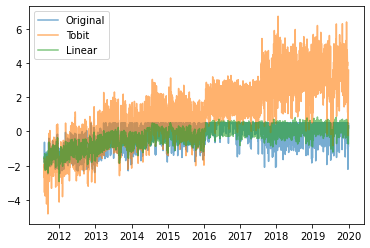

In [79]:
plt.plot(testdata["Energy (kWh)"], label = "Original", alpha = 0.6)
plt.plot(testdata.index,pred_tobit, label = "Tobit", alpha = 0.6)
plt.plot(testdata.index,pred, label = "Linear", alpha = 0.6)

plt.legend()
plt.show()

In [38]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][(df.Label == 0.0)][5:], pred_tobit))

22.43600091870775

In [39]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][(df.Label == 0.0)][5:], pred))

22.45659122222162

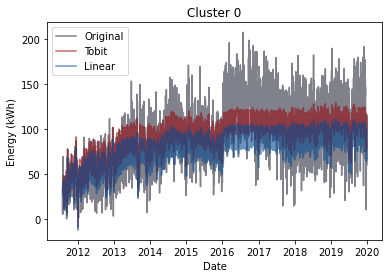

In [341]:
cmap = plt.cm.bone
rmap = plt.cm.Reds
bmap = plt.cm.Blues

plt.plot(df["Energy (kWh)"][df.Label == 0.0], label = "Original", alpha = 0.6, color=cmap(0.2))
plt.plot(testdata.index,pred_tobit, label = "Tobit", alpha = 0.6, color=rmap(0.9))
plt.plot(testdata.index,pred, label = "Linear", alpha = 0.6, color=bmap(0.9))
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.title("Cluster 0")
plt.legend()
plt.show()

In [324]:
r2_score(df["Energy (kWh)"][df.Label == 0.0][5:], pred_tobit)

0.5576782641226523

In [325]:
r2_score(df["Energy (kWh)"][df.Label == 0.0][5:], pred)

0.42260574711624244

In [28]:
from sklearn.metrics import mean_absolute_error



In [29]:
mean_absolute_error(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.3165387656320173

In [30]:
mean_absolute_error(df["Energy (kWh)"][df.Label == 0.0], pred)

0.31109770821282523

In [31]:
mean_squared_error(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.1738560036810394

In [32]:
mean_squared_error(df["Energy (kWh)"][df.Label == 0.0], pred)

0.16970687574924748